In [309]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
from itertools import cycle
from sklearn import metrics
from scipy import interp
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [310]:
img_width, img_height = 300, 250

train_data_dir = 'cytology_xmass_07_01_22_1/train'
#validation_data_dir = '../input/main-dataset/main_dataset/validation'
test_data_dir = 'cytology_xmass_07_01_22_1/test'
nb_train_samples = 86
nb_validation_samples = 32
epochs = 50
batch_size = 16
#regularizer = tf.keras.regularizers.l2(0.01,)

#if K.image_data_format() == 'channels_first':
#  input_shape = (3, img_width, img_height)
#else:
input_shape = (img_width, img_height, 3)

In [311]:
train_datagen = ImageDataGenerator(
    #rescale = 1./255,
    #shear_range = 0.3,
    #zoom_range = 0.2,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip = True
)

test_datagen = ImageDataGenerator(#rescale = 1./255
)

In [312]:
train_batches = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    #classes=['EOISINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'],
    class_mode = 'categorical')

Found 86 images belonging to 4 classes.


In [314]:
test_batches = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = 32,
    #color_mode = 'grayscale',
    class_mode = 'categorical')

Found 32 images belonging to 4 classes.


In [316]:
def plots(ims, figsize=(12,6), rows=None, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [317]:
imgs, labels = next(train_batches)

In [318]:
#model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [319]:
#Eoisinophil=8[1.0.0.0],Lymphocyte=4[0.1.0.0],monocyte=2[0.0.1.0],neutrophil=1[0.0.0.1]-->Labels
#plots(imgs, rows=4, titles=labels)

In [320]:
#model = Sequential()

#model.add(Conv2D(32, kernel_size=(11,11), strides= 4,
#                        padding= 'valid', activation= 'relu',
#                        input_shape= input_shape,
#                        kernel_initializer= 'he_normal'))
#model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
#                              padding= 'valid', data_format= None))

#model.add(Conv2D(256, kernel_size=(5,5), strides= 1,
#                        padding= 'same', activation= 'relu',
#                        kernel_initializer= 'he_normal'))
#model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
#                              padding= 'valid', data_format= None)) 

#model.add(Conv2D(384, kernel_size=(3,3), strides= 1,
#                        padding= 'same', activation= 'relu',
#                        kernel_initializer= 'he_normal'))

#model.add(Conv2D(384, kernel_size=(3,3), strides= 1,
#                        padding= 'same', activation= 'relu',
#                        kernel_initializer= 'he_normal'))

#model.add(Conv2D(256, kernel_size=(3,3), strides= 1,
#                        padding= 'same', activation= 'relu',
#                        kernel_initializer= 'he_normal'))

#model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
#                              padding= 'valid', data_format= None))

#model.add(Flatten())
#model.add(Dense(4096, activation= 'relu'))
#model.add(Dense(4096, activation= 'relu'))
#model.add(Dense(1000, activation= 'relu'))
#model.add(Dense(4, activation= 'softmax'))

#model.compile(optimizer= tf.keras.optimizers.Adam(0.001),
#                    loss='categorical_crossentropy',
#                    metrics=['accuracy'])

In [321]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(300,250,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [322]:
%%time
h = model.fit_generator(
    train_batches,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = test_batches,
    validation_steps = nb_validation_samples // batch_size,
    #callbacks=[
    #    tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/model_{val_accuracy:.3f}.h5', save_best_only=True,
    #                                      save_weights_only=False, monitor='val_accuracy')
    #]
)

Epoch 1/50


c:\users\terraform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


5/5 [==============================] - 21s 3s/step - loss: 37.1107 - accuracy: 0.3286 - val_loss: 114939.5391 - val_accuracy: 0.2500
Epoch 2/50
5/5 [==============================] - 10s 2s/step - loss: 94.5953 - accuracy: 0.4143
Epoch 3/50
5/5 [==============================] - 9s 2s/step - loss: 40.7601 - accuracy: 0.5143
Epoch 4/50
5/5 [==============================] - 9s 2s/step - loss: 59.0680 - accuracy: 0.3857
Epoch 5/50
5/5 [==============================] - 9s 2s/step - loss: 50.9210 - accuracy: 0.5143
Epoch 6/50
5/5 [==============================] - 10s 2s/step - loss: 13.8951 - accuracy: 0.5714
Epoch 7/50
5/5 [==============================] - 9s 2s/step - loss: 8.4492 - accuracy: 0.7429
Epoch 8/50
5/5 [==============================] - 9s 2s/step - loss: 8.4816 - accuracy: 0.6429
Epoch 9/50
5/5 [==============================] - 10s 2s/step - loss: 7.1698 - accuracy: 0.7125
Epoch 10/50
5/5 [==============================] - 10s 2s/step - loss: 6.5095 - accuracy: 0.7500
Ep

In [323]:
test_imgs, test_labels = next(test_batches)
#plots(test_imgs, rows=10, titles=test_labels)

In [324]:
rounded_labels = np.argmax(test_labels, axis=-1)

In [325]:
model.save('model_0.92015.h5')
test_model = load_model('model_0.92015.h5')

In [326]:
predictions = test_model.predict_generator(test_batches, steps=1, verbose=0)

c:\users\terraform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [327]:
predictions

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.10840639e-17, 1.00000000e+00, 2.41010350e-14, 0.00000000e+00],
       [3.39532294e-03, 9.96604681e-01, 2.17896981e-15, 1.26459708e-24],
       [6.08951141e-23, 1.00000000e+00, 4.41164269e-19, 0.00000000e+00],
       [2.58563971e-32, 1.80016110e-21, 6.69558965e-34, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.75758499e-26, 1.24623036e-15, 5.72139479e-31, 1.00000000e+00],
       [8.79231870e-01, 1.20768152e-01, 4.82468145e-12, 6.48412059e-21],
       [1.28126028e-16, 1.00000000e+00, 1.72337185e-08, 0.00000000e+00],
       [9.66135561e-01, 3.38644981e-02, 4.90492322e-16, 1.53790971e-28],
       [1.28126028e-16, 1.00000000e+00, 1.72337185e-08, 0.00000000e+00],
       [3.74765239e-28, 3.37938850e-08, 9.99999762e-01, 1.61301884e-07],
       [1.00000000e+00, 6.13401474e-13, 9.46459379e

In [328]:
rounded_prediction = np.argmax(predictions, axis=-1)

In [329]:
for i in rounded_prediction:
    print(i)

0
1
1
1
3
0
3
3
0
1
0
1
2
0
0
1
1
2
3
2
2
1
1
1
2
2
2
3
3
2
2
0


In [330]:
cm = confusion_matrix(y_true=rounded_labels, y_pred=rounded_prediction)

In [331]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[6 2 0 0]
 [1 6 0 1]
 [0 1 7 0]
 [0 1 2 5]]


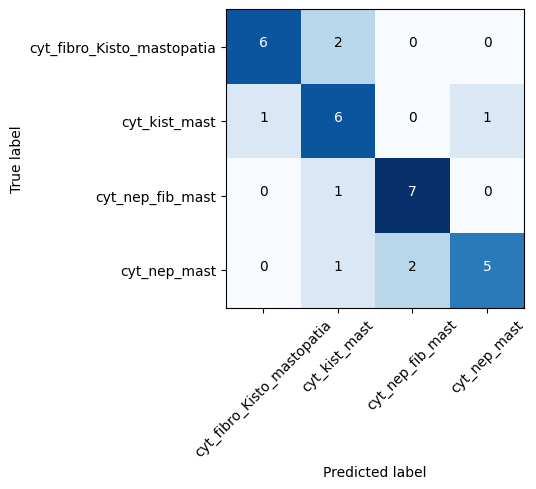

In [332]:
cm_plot_labels = ['cyt_fibro_Kisto_mastopatia', 'cyt_kist_mast', 'cyt_nep_fib_mast', 'cyt_nep_mast']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

c:\users\terraform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


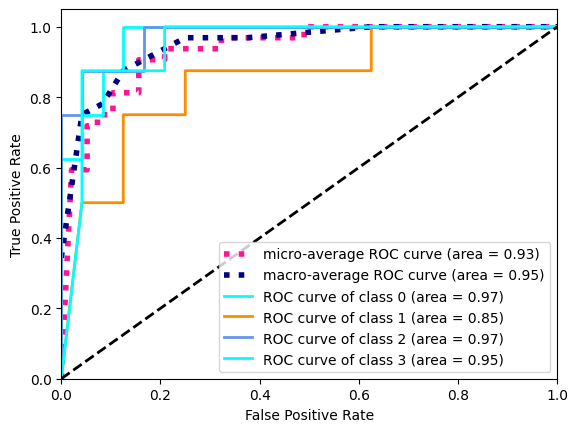

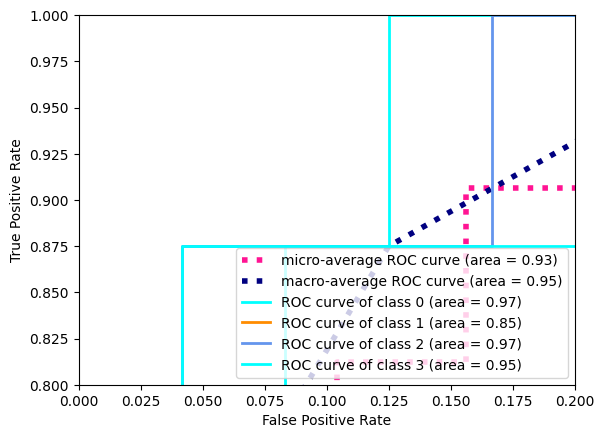

In [334]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



In [335]:
from sklearn.metrics import classification_report

In [336]:
print(classification_report(y_true=rounded_labels, y_pred=rounded_prediction))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         8
           2       0.78      0.88      0.82         8
           3       0.83      0.62      0.71         8

    accuracy                           0.75        32
   macro avg       0.77      0.75      0.75        32
weighted avg       0.77      0.75      0.75        32



In [337]:
score = metrics.log_loss(test_labels,predictions)
print("Log loss score: {}".format(score))

Log loss score: 4.324023858009269


ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

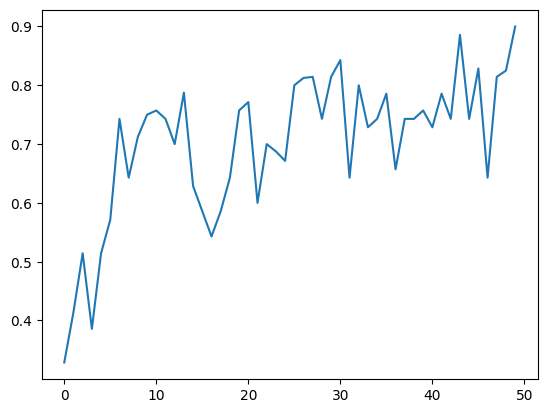

In [338]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
accs = h.history['loss']
val_accs = h.history['val_loss']

plt.plot(range(len(accs)),accs, label = 'Training_loss')
plt.plot(range(len(accs)),val_accs, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()